In [1]:
import torch
from torchinfo import summary
from torchvision import transforms
from matplotlib import pyplot as plt

from networks_medium import Encoder, Decoder
from Autoencoders import ConformalAutoencoder
from data import CelebA

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

/home/dgalperi/anaconda3/envs/max/lib/python3.13/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


device(type='cuda', index=1)

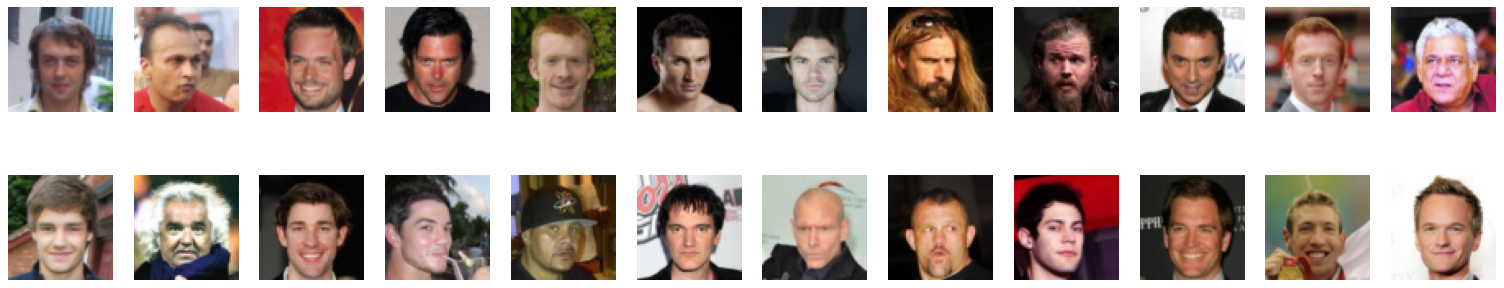

In [2]:
transform = [transforms.CenterCrop((178, 178)), transforms.Resize((64, 64))]
train_dataset = CelebA(root_dir="../", split="train", transform=transform, device=device, filter_categories=[(15, False), (20, True)])
val_dataset = CelebA(root_dir="../", split="val", transform=transform, device=device, filter_categories=[(15, False), (20, True)])

# show 2 rows of 12 images from train dataset
plt.figure(figsize=(24, 5), dpi=80)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(train_dataset[i][0].cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [3]:
z_dim = 1024
in_ch = 3
out_ch = 3
base_ch = 32 #64
gap_ch = 3

encoder = Encoder(z_dim=z_dim, in_ch=in_ch, base_ch=base_ch, gap_ch=gap_ch)
decoder = Decoder(z_dim=z_dim, out_ch=out_ch, base_ch=base_ch, gap_ch=gap_ch)
encoder._build_fc_if_needed(16, 16)
decoder._build_fc_if_needed(16, 16)

In [19]:
summary(encoder, input_size=(1, in_ch, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 1024]                 --
├─ConvBNReLU: 1-1                        [1, 32, 64, 64]           --
│    └─Sequential: 2-1                   [1, 32, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 32, 64, 64]           864
│    │    └─BatchNorm2d: 3-2             [1, 32, 64, 64]           64
│    │    └─ReLU: 3-3                    [1, 32, 64, 64]           --
├─ConvBNReLU: 1-2                        [1, 64, 32, 32]           --
│    └─Sequential: 2-2                   [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-4                  [1, 64, 32, 32]           18,432
│    │    └─BatchNorm2d: 3-5             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-6                    [1, 64, 32, 32]           --
├─ConvBNReLU: 1-3                        [1, 64, 32, 32]           --
│    └─Sequential: 2-3                   [1, 64, 32, 32]           --
│    │   

In [4]:
from metrics import conformality_cosine_loss, conformality_trace_loss

lambda_conf = 0.1 #0.0023294465621657994
lambda_reg = 5.6e-4 #5.593799193170297e-07
lambda_aug = 0.1

conformal_autoencoder = ConformalAutoencoder(encoder, decoder,
                                             lambda_conf=lambda_conf, 
                                             lambda_reg=lambda_reg,
                                             reg_in_loss=True,
                                             lambda_aug=lambda_aug
                                             ).to(device)

conformal_autoencoder.conformality_loss = conformality_cosine_loss
conformal_autoencoder.reconstruction_loss = torch.nn.L1Loss()

In [5]:
bs = 512
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4, pin_memory=True)

In [6]:
# If you want to load a model from checkpoint, uncomment the following lines:

# conformal_autoencoder.encoder._build_fc_if_needed(16,16)
# conformal_autoencoder.decoder._build_fc_if_needed(16,16)
# conformal_autoencoder.load_model_from_checkpoint("models/path.pth")

In [7]:
# if you want to load optimizer and scheduler state from checkpoint, uncomment the following lines (and include optimizer and scheduler in train_model call):

# optimizer = torch.optim.Adam(conformal_autoencoder.parameters(), lr=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
# optimizer.load_state_dict(torch.load("models/celeba_autoencoder_v3_3_optimizer.pth"))
# scheduler.load_state_dict(torch.load("models/celeba_autoencoder_v3_3_scheduler.pth"))


In [8]:
epochs = 400
optimizer, scheduler = conformal_autoencoder.train_model(train_loader,
                                                         val_loader,
                                                         has_label=True,
                                                         epochs=epochs,
                                                         batch_size=bs,
                                                         learning_rate=1e-3,
                                                         val_every=10,
                                                         scheduler_kwargs={"step_size":20, "gamma":0.85}
                                                         )

Epoch [10/400], Validation Loss: 0.03766834, Reconstruction Loss: 0.03731982, Conformal Loss: 0.00341126, Regularization Loss: 0.01318776


Epoch [20/400], Validation Loss: 0.03035790, Reconstruction Loss: 0.03010214, Conformal Loss: 0.00253959, Regularization Loss: 0.00321594


Epoch [30/400], Validation Loss: 0.02884412, Reconstruction Loss: 0.02860631, Conformal Loss: 0.00236862, Regularization Loss: 0.00170389


Epoch [40/400], Validation Loss: 0.02733455, Reconstruction Loss: 0.02711673, Conformal Loss: 0.00215871, Regularization Loss: 0.00348434


Epoch [50/400], Validation Loss: 0.02465439, Reconstruction Loss: 0.02445463, Conformal Loss: 0.00199362, Regularization Loss: 0.00070906


Epoch [60/400], Validation Loss: 0.02448572, Reconstruction Loss: 0.02429838, Conformal Loss: 0.00186748, Regularization Loss: 0.00105669


Epoch [70/400], Validation Loss: 0.02506125, Reconstruction Loss: 0.02487627, Conformal Loss: 0.00184803, Regularization Loss: 0.00031271


Epoch [80/400], Validation Loss: 0.02370430, Reconstruction Loss: 0.02352340, Conformal Loss: 0.00180306, Regularization Loss: 0.00107409


Epoch [90/400], Validation Loss: 0.02326526, Reconstruction Loss: 0.02308615, Conformal Loss: 0.00178880, Regularization Loss: 0.00040815


Epoch [100/400], Loss: 0.02317917, Reconstruction Loss: 0.02300511, Conformal Loss: 0.00173841, Regularization Loss: 0.00039003


Epoch [100/400], Validation Loss: 0.02309463, Reconstruction Loss: 0.02291670, Conformal Loss: 0.00177599, Regularization Loss: 0.00059758


Epoch [110/400], Validation Loss: 0.02251733, Reconstruction Loss: 0.02235075, Conformal Loss: 0.00166401, Regularization Loss: 0.00031816


Epoch [120/400], Validation Loss: 0.02263768, Reconstruction Loss: 0.02246922, Conformal Loss: 0.00168123, Regularization Loss: 0.00060937


Epoch [130/400], Validation Loss: 0.02331748, Reconstruction Loss: 0.02315362, Conformal Loss: 0.00163732, Regularization Loss: 0.00023192


Epoch [140/400], Validation Loss: 0.02224886, Reconstruction Loss: 0.02208344, Conformal Loss: 0.00164958, Regularization Loss: 0.00082216


Epoch [150/400], Validation Loss: 0.02197018, Reconstruction Loss: 0.02180497, Conformal Loss: 0.00165053, Regularization Loss: 0.00027222


Epoch [160/400], Validation Loss: 0.02151710, Reconstruction Loss: 0.02135650, Conformal Loss: 0.00160457, Regularization Loss: 0.00024699


Epoch [170/400], Validation Loss: 0.02149855, Reconstruction Loss: 0.02133693, Conformal Loss: 0.00161352, Regularization Loss: 0.00047504


Epoch [180/400], Validation Loss: 0.02161181, Reconstruction Loss: 0.02145549, Conformal Loss: 0.00156098, Regularization Loss: 0.00039025


Epoch [190/400], Validation Loss: 0.02160643, Reconstruction Loss: 0.02145364, Conformal Loss: 0.00152632, Regularization Loss: 0.00029897


Epoch [200/400], Loss: 0.02184988, Reconstruction Loss: 0.02169530, Conformal Loss: 0.00154434, Regularization Loss: 0.00024919


Epoch [200/400], Validation Loss: 0.02192556, Reconstruction Loss: 0.02176958, Conformal Loss: 0.00155520, Regularization Loss: 0.00082312


Epoch [210/400], Validation Loss: 0.02166587, Reconstruction Loss: 0.02150757, Conformal Loss: 0.00157400, Regularization Loss: 0.00159000


Epoch [220/400], Validation Loss: 0.02128767, Reconstruction Loss: 0.02113564, Conformal Loss: 0.00151875, Regularization Loss: 0.00028758


Epoch [230/400], Validation Loss: 0.02104781, Reconstruction Loss: 0.02089272, Conformal Loss: 0.00154967, Regularization Loss: 0.00023136


Epoch [240/400], Validation Loss: 0.02121142, Reconstruction Loss: 0.02105826, Conformal Loss: 0.00152875, Regularization Loss: 0.00051854


Epoch [250/400], Validation Loss: 0.02110091, Reconstruction Loss: 0.02094785, Conformal Loss: 0.00152875, Regularization Loss: 0.00031315


Epoch [260/400], Validation Loss: 0.02099710, Reconstruction Loss: 0.02084231, Conformal Loss: 0.00154541, Regularization Loss: 0.00044372


Epoch [270/400], Validation Loss: 0.02095763, Reconstruction Loss: 0.02080765, Conformal Loss: 0.00149790, Regularization Loss: 0.00032627


Epoch [280/400], Validation Loss: 0.02097463, Reconstruction Loss: 0.02082392, Conformal Loss: 0.00150436, Regularization Loss: 0.00049212


Epoch [290/400], Validation Loss: 0.02092610, Reconstruction Loss: 0.02077392, Conformal Loss: 0.00151635, Regularization Loss: 0.00096422


Epoch [300/400], Loss: 0.02108331, Reconstruction Loss: 0.02093456, Conformal Loss: 0.00148580, Regularization Loss: 0.00030146


Epoch [300/400], Validation Loss: 0.02087723, Reconstruction Loss: 0.02072675, Conformal Loss: 0.00149956, Regularization Loss: 0.00093867


Epoch [310/400], Validation Loss: 0.02081962, Reconstruction Loss: 0.02067095, Conformal Loss: 0.00148473, Regularization Loss: 0.00034027


Epoch [320/400], Validation Loss: 0.02080677, Reconstruction Loss: 0.02066008, Conformal Loss: 0.00146501, Regularization Loss: 0.00034382


Epoch [330/400], Validation Loss: 0.02077866, Reconstruction Loss: 0.02062883, Conformal Loss: 0.00149629, Regularization Loss: 0.00036669


Epoch [340/400], Validation Loss: 0.02074625, Reconstruction Loss: 0.02059613, Conformal Loss: 0.00149930, Regularization Loss: 0.00034452


Epoch [350/400], Validation Loss: 0.02072955, Reconstruction Loss: 0.02058141, Conformal Loss: 0.00147915, Regularization Loss: 0.00039996


Epoch [360/400], Validation Loss: 0.02072325, Reconstruction Loss: 0.02057546, Conformal Loss: 0.00147457, Regularization Loss: 0.00059285


Epoch [370/400], Validation Loss: 0.02070808, Reconstruction Loss: 0.02056018, Conformal Loss: 0.00147740, Regularization Loss: 0.00028902


Epoch [380/400], Validation Loss: 0.02071298, Reconstruction Loss: 0.02056654, Conformal Loss: 0.00146265, Regularization Loss: 0.00031629


Epoch [390/400], Validation Loss: 0.02066723, Reconstruction Loss: 0.02052130, Conformal Loss: 0.00145764, Regularization Loss: 0.00029748


Epoch [400/400], Loss: 0.02076099, Reconstruction Loss: 0.02061572, Conformal Loss: 0.00145152, Regularization Loss: 0.00018877


Epoch [400/400], Validation Loss: 0.02064512, Reconstruction Loss: 0.02050030, Conformal Loss: 0.00144680, Regularization Loss: 0.00023813


In [9]:
conformal_autoencoder.save_checkpoint("models/celeba_conformal_autoencoder_v1_2.pth") # z_dim = 1024, lambda_conf = 0.1, lambda_reg = 5.6e-4

Checkpoint saved to models/celeba_conformal_autoencoder_v1_2.pth at epoch 401


In [10]:
torch.save(optimizer.state_dict(), "models/celeba_autoencoder_v1_2_optimizer.pth")
torch.save(scheduler.state_dict(), "models/celeba_autoencoder_v1_2_scheduler.pth")

In [ ]:
# conformal_autoencoder.load_model_from_checkpoint("models/celeba_conformal_autoencoder_v3_3.pth")

Model and custom variables loaded from models/celeba_conformal_autoencoder_v3_3.pth


ConformalAutoencoder(
  (encoder): Encoder(
    (conv0): ConvBNReLU(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (down1): ConvBNReLU(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (conv1): ConvBNReLU(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (down2): ConvBNReLU(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2,

In [11]:
#get current learning rate
for param_group in optimizer.param_groups:
    current_lr = param_group['lr']
    break
print(f"Current learning rate: {current_lr}")

Current learning rate: 3.875953108451434e-05


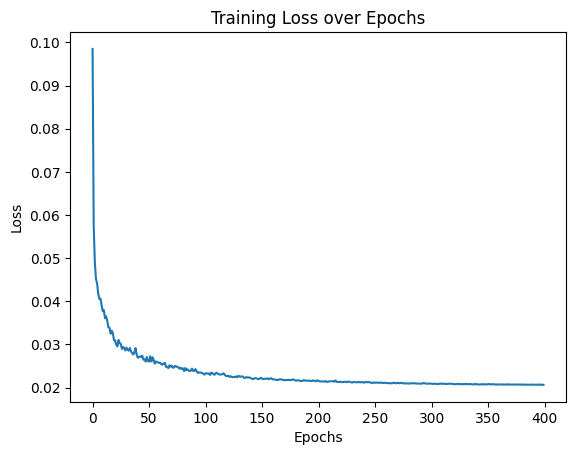

In [12]:
plt.plot(conformal_autoencoder.metrics_list["reconstruction_loss"][:], label="Reconstruction Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

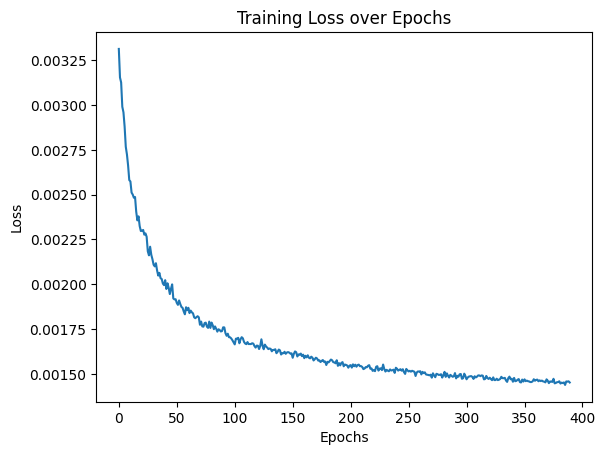

In [18]:
plt.plot(conformal_autoencoder.metrics_list["conformal_loss"][10:], label="Conformal Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

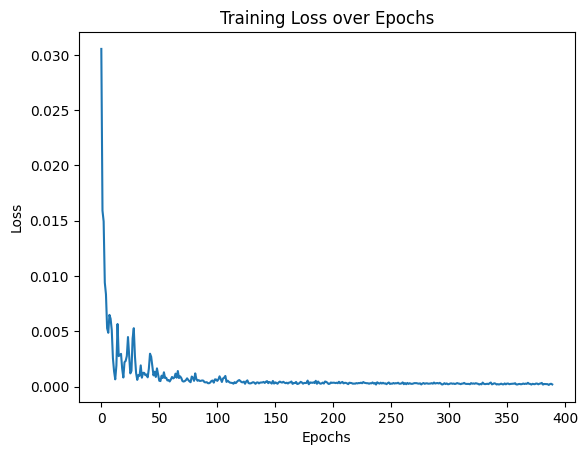

In [14]:
plt.plot(conformal_autoencoder.metrics_list["regularization_loss"][10:], label="Regularization Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

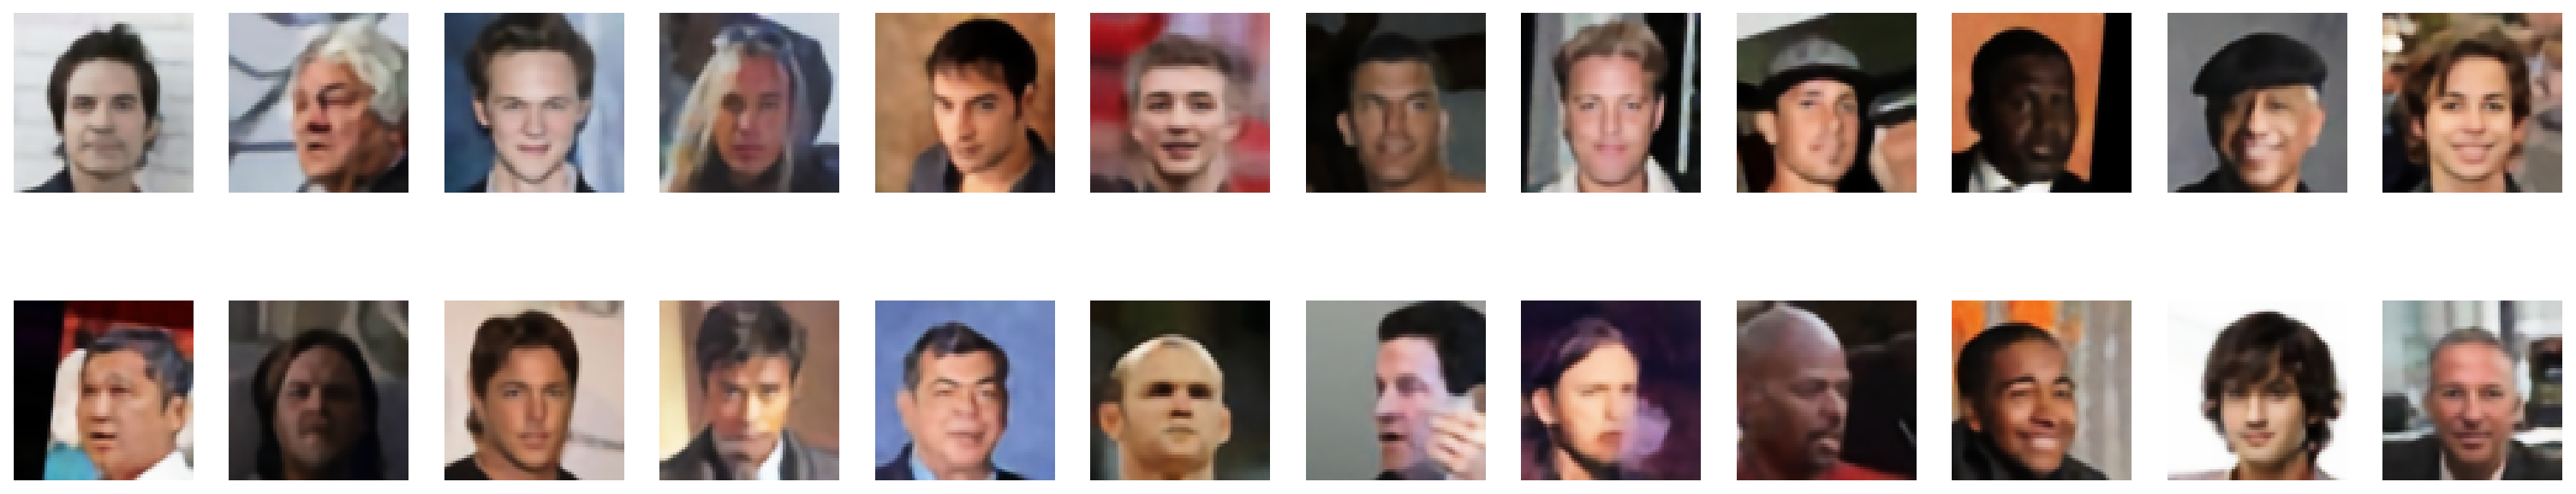

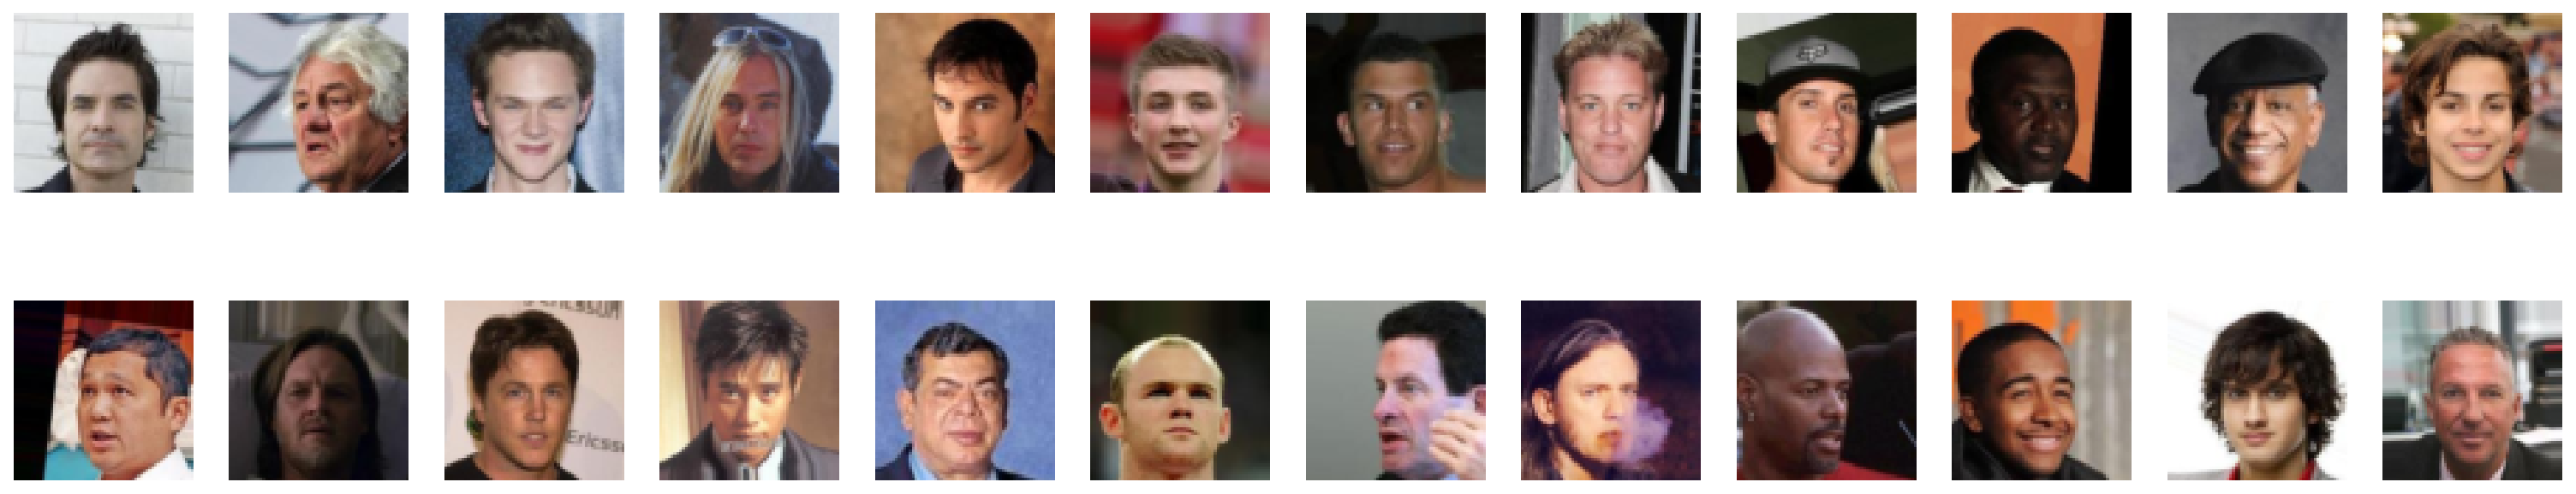

In [15]:
samples = conformal_autoencoder.forward(val_dataset.get_sample(24, seed=32)[0].to(device))
plt.figure(figsize=(24, 5), dpi=160)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(samples[i].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()
plt.figure(figsize=(24, 5), dpi=160)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(val_dataset.get_sample(24, seed=32)[0][i].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()

In [17]:
from metrics_copy import evaluate_conformality

evaluate_conformality(conformal_autoencoder, val_dataset.get_sample(200, seed=42)[0].to(device), chunk_size=64)

tensor([0., 0., 0., -0., 0., -0., -0., 0., 0., -0., 0., 0., 0., -0., 0., 0., 0., 0., 0., 0., -0., 0., -0., 0.,
        0., 0., -0., 0., -0., -0., 0., -0., 0., 0., 0., 0., 0., -0., -0., 0., -0., 0., -0., 0., -0., 0., -0., -0.,
        -0., -0., 0., 0., -0., 0., -0., 0., 0., -0., 0., -0., -0., -0., -0., 0., 0., 0., 0., -0., -0., 0., 0., -0.,
        -0., -0., 0., 0., 0., 0., -0., -0., -0., -0., -0., 0., -0., 0., 0., 0., 0., 0., 0., -0., -0., 0., -0., 0.,
        -0., 0., -0., -0., -0., 0., -0., 0., -0., 0., -0., -0., 0., 0., -0., -0., -0., 0., 0., -0., -0., -0., 0., -0.,
        0., 0., -0., 0., 0., 0., 0., -0., 0., 0., 0., -0., -0., -0., -0., 0., 0., -0., -0., 0., 0., -0., 0., -0.,
        -0., 0., 0., 0., 0., -0., 0., -0., 0., -0., 0., 0., 0., -0., -0., -0., 0., -0., 0., 0., 0., -0., -0., 0.,
        0., 0., 0., -0., -0., -0., 0., 0., -0., -0., 0., 0., 0., 0., 0., -0., 0., -0., -0., 0., -0., -0., -0., 0.,
        -0., 0., -0., 0., -0., -0., 0., -0.], device='cuda:1',
       dtype=torch

{'Reconstruction Error': 0.0010876854648813605,
 'Diagonal Uniformity (gini)': 0.06424140185117722,
 'Conformal Factor Mean': 0.9251828789710999,
 'Conformal Factor Std': 0.28446170687675476,
 'Conformal Factor Std (normalized)': 0.3074653744697571,
 'Conformal Factor Estimate Error': 0.011204704642295837,
 'Conformal Factor Estimate Error (normalized)': 0.012110798619687557,
 'Off-diagonal Mean': 0.028086749836802483,
 'Off-diagonal Mean (normalized)': 0.03178125247359276,
 'Off-diagonal Norm': 36.4461669921875,
 'Off-diagonal Norm (normalized)': 41.23998260498047,
 'Conformality Mean': 0.028167402371764183,
 'Conformality Mean (normalized)': 0.031869325786828995,
 'Conformality Norm': 36.60541534423828,
 'Conformality Norm (normalized)': 41.40849685668945,
 'Determinant Estimation Error': 3.0867465208103993e+116,
 'Determinant Estimation Error (normalized)': 2.5893506558442282e+123,
 'Determinant Estimation from Estimate Error': 1.505996297583708e+119,
 'Determinant Estimation from E

In [17]:
from metrics_copy import evaluate_conformality

evaluate_conformality(conformal_autoencoder, val_dataset.get_sample(50, seed=42)[0].to(device), chunk_size=64)

tensor([-0., 0., 0., 0., 0., 0., 0., 0., 0., -0., 0., -0., 0., -0., 0., 0., 0., -0., 0., 0., 0., 0., 0., 0.,
        0., -0., -0., -0., 0., 0., -0., 0., 0., -0., 0., 0., 0., 0., -0., 0., 0., 0., 0., 0., 0., 0., 0., -0.,
        -0., 0.], device='cuda:1', dtype=torch.float64)
tensor([ 2.2173e-25,  7.4194e-44,  4.3408e-64,  2.8880e-18,  0.0000e+00,
         2.9267e+75,  3.7019e-84,  3.4641e-25,  1.0359e-46,  3.2880e-05,
         2.1001e-55,  2.3429e+29,  8.3872e-17,  3.7299e+37,  1.2778e-69,
         4.0851e+60,  7.6985e-48,  3.2012e+21,  0.0000e+00,  0.0000e+00,
         5.2076e-21, 7.5465e-117,  5.3248e-63,  6.0503e+14,  4.2732e-68,
         3.5697e-03,  2.8057e+16,  7.2277e-04,  7.6279e+03,  1.9997e-69,
         1.0648e-69,  1.7308e+23,  5.5891e+65,  2.6742e+35,  3.5089e-45,
        2.3216e-147, 5.8321e-120,  1.0807e-69,  1.7515e-56, 4.3175e-128,
        1.0654e-107, 1.1197e-116, 1.8949e-102,  1.4628e+22,  9.0052e+29,
         4.7335e-13,  6.2150e+13,  3.5871e-64,  6.3214e-48,  1.0538

{'Reconstruction Error': 0.0012431675568223,
 'Diagonal Uniformity (gini)': 0.06435694545507431,
 'Conformal Factor Mean': 0.873450517654419,
 'Conformal Factor Std': 0.2452067732810974,
 'Conformal Factor Std (normalized)': 0.2807334363460541,
 'Conformal Factor Estimate Error': 0.013668956235051155,
 'Conformal Factor Estimate Error (normalized)': 0.015649374574422836,
 'Off-diagonal Mean': 0.02923824079334736,
 'Off-diagonal Mean (normalized)': 0.03460733965039253,
 'Off-diagonal Norm': 38.08094787597656,
 'Off-diagonal Norm (normalized)': 45.084354400634766,
 'Conformality Mean': 0.029315007850527763,
 'Conformality Mean (normalized)': 0.03469615429639816,
 'Conformality Norm': 38.21329879760742,
 'Conformality Norm (normalized)': 45.23488235473633,
 'Determinant Estimation Error': 5.853302243946135e+73,
 'Determinant Estimation Error (normalized)': 4.91010580299845e+80,
 'Determinant Estimation from Estimate Error': 3.4035229830065884e+77,
 'Determinant Estimation from Estimate Er